<a href="https://colab.research.google.com/github/harshiitsingh/Disease-Diagnosis-Platform/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer: Malignant vs. Benign

- Dataset Link: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign

- This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.

- The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

- Benign: benign (not cancerous). A benign tumor is usually not a serious problem unless it presses on a nearby structure or causes other symptoms. Not cancer. Benign tumors may grow larger but do not spread to other parts of the body. Also called nonmalignant.

- Malignant: A tumor can be malignant (cancerous) 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Kaggle initialization and fetch dataset

Installing the needed libraries and uploading the kaggle auth json file.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Downloading the dataset form the kaggle API - [Pneumonia X-Ray Images](https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images)

In [ ]:
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

100% 325M/325M [00:15<00:00, 22.4MB/s]
100% 325M/325M [00:15<00:00, 22.2MB/s]


Unzip the downloaded dataset and move to the desired target folder using the zipfile library

In [ ]:
import zipfile
zf = "/content/skin-cancer-malignant-vs-benign.zip"
target_dir = "/content/skin-cancer"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# Basic imports and parameters

In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.model_selection
import sklearn.utils.class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model,Sequential
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential # for stacking the neural layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger

In [ ]:
#Define Directories for train, test & Validation Set
train_path = '/content/skin-cancer/train'
test_path = '/content/skin-cancer/test'

In [ ]:

#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 32
# dimensions of our images.
img_width, img_height = 224, 224

## Image directory to .csv file

Converting the directory of train and val images to .csv files. Merging both datsets into one dataframe.

In [ ]:
files_in_annotated = sorted(os.listdir(train_path))

image=[]
label=[]
for file in files_in_annotated:
    for img in os.listdir(train_path+'/'+file):
        image.append(train_path+'/'+file+'/'+img)
        label.append(file)

In [ ]:
df = pd.DataFrame()
df['images']=[str(x) for x in image]
df['labels']=[str(x) for x in label]
# df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.to_csv('files_path.csv', header=None)
df.head()

,images,labels
0,/content/skin-cancer/train/benign/799.jpg,benign
1,/content/skin-cancer/train/benign/1397.jpg,benign
2,/content/skin-cancer/train/benign/368.jpg,benign
3,/content/skin-cancer/train/benign/879.jpg,benign
4,/content/skin-cancer/train/benign/1777.jpg,benign


## Plotting images

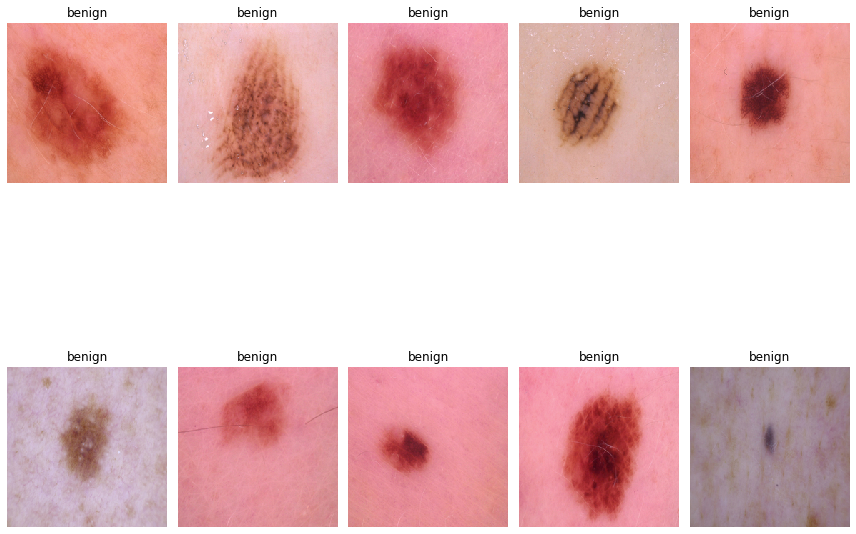

In [ ]:
import cv2 as cv
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for index in df.index:
        image = cv.imread(df.images[i])
        image= cv.cvtColor(image, cv.COLOR_RGB2BGR)
        plt.title(df.labels[i])
        plt.axis('off')
        plt.imshow(np.squeeze(image),interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# CNN

## Augmentation

In [ ]:
# Create Image Data Generator for Train Set
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,  
                                  vertical_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

**Architecture**

In [ ]:
def create_model_xception():
    #load pre trained Xception model
    model = tf.keras.Sequential([
        Xception(include_top=False,input_tensor=None,input_shape=(224,224,3),classes=2,weights='imagenet', classifier_activation='softmax'),

        # Rebuild top
        layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    return model

xception = create_model_xception()
xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_14 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                      

In [ ]:
def create_model_vgg16():
    #load pre trained Xception model
    model = tf.keras.Sequential([
        VGG16(include_top=False,input_tensor=None,input_shape=(299,299,3),classes=2,weights='imagenet', classifier_activation='softmax'),

        # Rebuild top
        layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    return model

vgg16 = create_model_vgg16()
vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               10617088  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 

In [ ]:
def create_model_vgg19():
    #load pre trained Xception model
    model = tf.keras.Sequential([
        VGG19(include_top=False,input_tensor=None,input_shape=(299,299,3),classes=2,weights='imagenet', classifier_activation='softmax'),

        # Rebuild top
        layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    return model

vgg19 = create_model_vgg19()
vgg19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               10617088  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 

In [ ]:
def create_model_resnet50():
    model = tf.keras.Sequential([
        ResNet50(include_top=False,input_tensor=None,input_shape=(299,299,3),classes=2,weights='imagenet', classifier_activation='softmax'),
        layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.2)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name='auc')])
    return model

resnet50 = create_model_resnet50()
resnet50.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_3 (Flatten)         (None, 204800)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                13107264  
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 

In [ ]:
def create_model_resnet152():
    model = tf.keras.Sequential([
        ResNet152V2(include_top=False,input_tensor=None,input_shape=(299,299,3),classes=2,weights='imagenet', classifier_activation='softmax'),
        layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
    return model

resnet152 = create_model_resnet152()
resnet152.summary()

234561536/234545216 [==============================] - 6s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 flatten_4 (Flatten)         (None, 204800)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               52429056  
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)               

In [ ]:
def create_model_inception():
  pre_trained_model = InceptionV3(input_shape = (299,299,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

  for layer in pre_trained_model.layers:
    layer.trainable=False
  
  x =Flatten()(pre_trained_model.output)
  x=Dense(128,activation='relu')(x)
  x=Dropout(0.5)(x)
  
  x=Dense(1,activation='sigmoid')(x)
  model=Model(pre_trained_model.input,x)
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  return model

inception = create_model_inception()
inception.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                

**Define plot function**

In [ ]:
def plot_all(hist):
  print(hist.history.keys())
  # summarize history for accuracy
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for precision
  # plt.plot(hist.history['precision'])
  # plt.plot(hist.history['val_precision'])
  # plt.title('model precision')
  # plt.ylabel('preision')
  # plt.xlabel('epoch')
  # plt.legend(['train','val'], loc='upper left')
  # plt.show()
  # # summarize history for recall
  # plt.plot(hist.history['recall'])
  # plt.plot(hist.history['val_recall'])
  # plt.title('model recall')
  # plt.ylabel('recall')
  # plt.xlabel('epoch')
  # plt.legend(['train','val'], loc='upper left')
  # plt.show()
  # # summarize history for recall
  # plt.plot(hist.history['auc'])
  # plt.plot(hist.history['val_auc'])
  # plt.title('model auc')
  # plt.ylabel('TP rate')
  # plt.xlabel('FP rate')
  # plt.legend(['train','val'], loc='upper left')
  # plt.show()

## K-fold

In [ ]:
# Storing the average of all predictions

val_pred1 = []
val_pred2 = []
error = []
data_kfold = pd.DataFrame()

# Creating X, Y for training 

train_y = df.labels
train_x = df.drop(['labels'],axis=1)

Defining Callback list

In [ ]:
def callbacks(model_name, i):
    early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3)
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

    checkpoint_filepath ='/content/drive/MyDrive/skin-cancer/models/'+model_name+'/model(k='+str(i)+').hdf5'
    model_checkpoint_callback =ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

    callbacks_list = [ early, learning_rate_reduction, model_checkpoint_callback]

    return callbacks_list

In [ ]:
# k-fold
def cross_validate(model,model_name):
    kfold = skl.model_selection.StratifiedKFold(n_splits=5,shuffle=True)

    # Variable for keeping count of split we are executing
    j = 0

    for train_idx, val_idx in list(kfold.split(train_x,train_y)):
        x_train_df = df.iloc[train_idx]
        x_valid_df = df.iloc[val_idx]
        j+=1
        print("Iteration #" + str(j))

        training_set = image_gen.flow_from_dataframe(dataframe=x_train_df,
                                                    x_col="images", y_col="labels",
                                                    class_mode="binary",
                                                    target_size=(img_width,img_height), batch_size=batch_size)
        
        validation_set = test_data_gen.flow_from_dataframe(dataframe=x_valid_df,
                                                    x_col="images", y_col="labels",
                                                    class_mode="binary",
                                                    target_size=(img_width,img_height), batch_size=batch_size)


        print(model_name)
        # history = model.fit(training_set, validation_data=validation_set, callbacks=callbacks(model_name, j), epochs=20, verbose=1, batch_size= batch_size)
        history = model.fit(training_set, validation_data=validation_set, epochs=20, verbose=1, batch_size= batch_size)
        plot_all(history)

    # print("VGG16")
    # hist_vgg16 = vgg16.fit(training_set, validation_data=validation_set, callbacks=callbacks('vgg16', j), epochs=20, verbose=1, batch_size= batch_size)
    # plot_all(hist_vgg16)
    
    # print("VGG19")
    # hist_vgg19 = vgg19.fit(training_set, validation_data=validation_set, callbacks=callbacks('vgg19', j), epochs=20, verbose=1, batch_size= batch_size)
    # plot_all(hist_vgg19)

    # print("Resnet50")
    # hist_resnet50 = resnet50.fit(training_set, validation_data=validation_set, callbacks=callbacks('resnet50', j), epochs=20, verbose=1, batch_size= batch_size)
    # plot_all(hist_resnet50)
    
    # print("Resnet152")
    # hist_resnet152 = resnet152.fit(training_set, validation_data=validation_set, callbacks=callbacks('resnet152', j), epochs=20, verbose=1, batch_size= batch_size)
    # plot_all(hist_resnet152)

    # print("Inception")
    # hist_inception = inception.fit(training_set, validation_data=validation_set, callbacks=callbacks('inception', j), epochs=20, verbose=1, batch_size= batch_size)
    # plot_all(hist_inception)

Iteration #1
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
xception
Epoch 1/20
66/66 [==============================] - 44s 506ms/step - loss: 0.5770 - accuracy: 0.7677 - val_loss: 1.1254 - val_accuracy: 0.6856
Epoch 2/20
66/66 [==============================] - 27s 412ms/step - loss: 0.4150 - accuracy: 0.8141 - val_loss: 0.4735 - val_accuracy: 0.8220
Epoch 3/20
66/66 [==============================] - 27s 404ms/step - loss: 0.3844 - accuracy: 0.8326 - val_loss: 0.4119 - val_accuracy: 0.8295
Epoch 4/20
66/66 [==============================] - 27s 403ms/step - loss: 0.3411 - accuracy: 0.8355 - val_loss: 0.3953 - val_accuracy: 0.8277
Epoch 5/20
66/66 [==============================] - 27s 403ms/step - loss: 0.3333 - accuracy: 0.8535 - val_loss: 0.3963 - val_accuracy: 0.8333
Epoch 6/20
66/66 [==============================] - 27s 402ms/step - loss: 0.3233 - accuracy: 0.8615 - val_loss: 0.3926 - val_accuracy: 0.8466

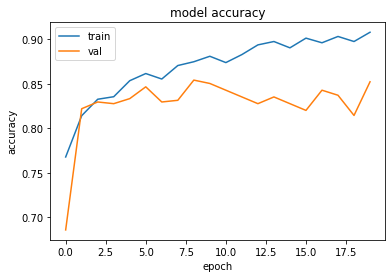

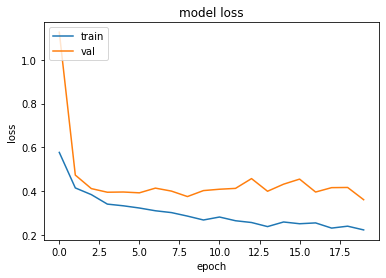

Iteration #2
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
xception
Epoch 1/20
66/66 [==============================] - 27s 402ms/step - loss: 0.2773 - accuracy: 0.8772 - val_loss: 0.2062 - val_accuracy: 0.9167
Epoch 2/20
66/66 [==============================] - 27s 402ms/step - loss: 0.2602 - accuracy: 0.8976 - val_loss: 0.1956 - val_accuracy: 0.9223
Epoch 3/20
66/66 [==============================] - 27s 412ms/step - loss: 0.2682 - accuracy: 0.8815 - val_loss: 0.2356 - val_accuracy: 0.8939
Epoch 4/20
66/66 [==============================] - 27s 403ms/step - loss: 0.2554 - accuracy: 0.8943 - val_loss: 0.2363 - val_accuracy: 0.9053
Epoch 5/20
57/66 [========================>.....] - ETA: 3s - loss: 0.2518 - accuracy: 0.8863

KeyboardInterrupt: ignored

In [ ]:
cross_validate(xception,'xception')

In [ ]:
# Evaluating the Predictions on the Model

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Saving the model for Future Inferences

model_json = xception.to_json()
with open("xception.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
xception.save_weights("model.h5")

Iteration #1
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
resnet50
Epoch 1/20
66/66 [==============================] - 67s 724ms/step - loss: 3.1548 - accuracy: 0.7511 - precision: 0.7303 - recall: 0.7158 - auc: 0.8349 - val_loss: 4.7473 - val_accuracy: 0.5455 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5024 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 46s 702ms/step - loss: 1.1953 - accuracy: 0.7771 - precision: 0.7650 - recall: 0.7346 - auc: 0.8617 - val_loss: 30.3435 - val_accuracy: 0.4545 - val_precision: 0.4545 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 1.3894 - accuracy: 0.7648 - precision: 0.7525 - recall: 0.7179 - auc: 0.8469
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 45s 675ms/step - loss: 1.3894 - accuracy: 0.76

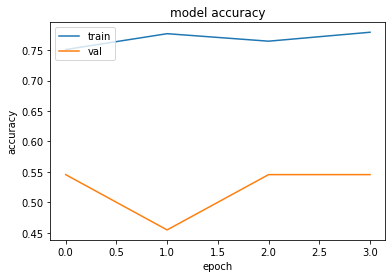

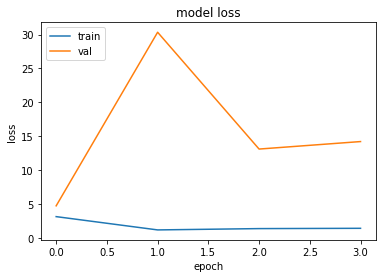

Iteration #2
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
resnet50
Epoch 1/20
66/66 [==============================] - 45s 681ms/step - loss: 1.0570 - accuracy: 0.7805 - precision: 0.7633 - recall: 0.7482 - auc: 0.8681 - val_loss: 9.0659 - val_accuracy: 0.5455 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 5.0000e-04
Epoch 2/20
66/66 [==============================] - 45s 686ms/step - loss: 0.8244 - accuracy: 0.7790 - precision: 0.7755 - recall: 0.7220 - auc: 0.8704 - val_loss: 45.9591 - val_accuracy: 0.4545 - val_precision: 0.4545 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 5.0000e-04
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.7847 - precision: 0.7737 - recall: 0.7429 - auc: 0.8696
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
66/66 [==============================] - 45s 676ms/step - loss: 0.8705 - accura

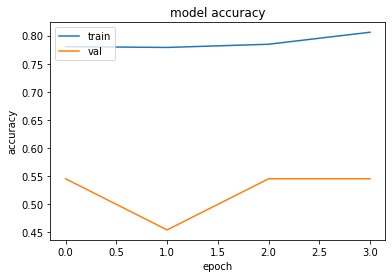

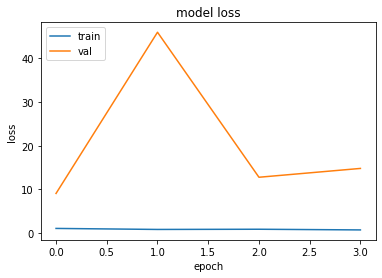

Iteration #3
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet50
Epoch 1/20
66/66 [==============================] - 48s 727ms/step - loss: 0.6310 - accuracy: 0.7924 - precision: 0.7790 - recall: 0.7578 - auc: 0.8808 - val_loss: 6.7491 - val_accuracy: 0.5465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 2.5000e-04
Epoch 2/20
66/66 [==============================] - 45s 684ms/step - loss: 0.6491 - accuracy: 0.7953 - precision: 0.7723 - recall: 0.7787 - auc: 0.8750 - val_loss: 13.1569 - val_accuracy: 0.5465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 2.5000e-04
Epoch 3/20
66/66 [==============================] - 43s 657ms/step - loss: 0.6088 - accuracy: 0.7995 - precision: 0.7755 - recall: 0.7860 - auc: 0.8805 - val_loss: 1.8653 - val_accuracy: 0.4573 - val_precision: 0.4552 - val_recall: 1.0000 - val_auc: 0.8885 - lr: 2.5000e-04
Epoch 4/20
66/66 [

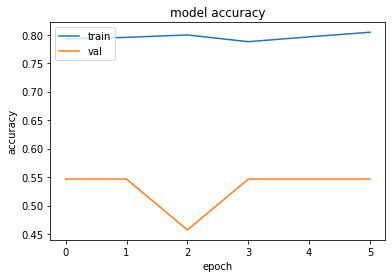

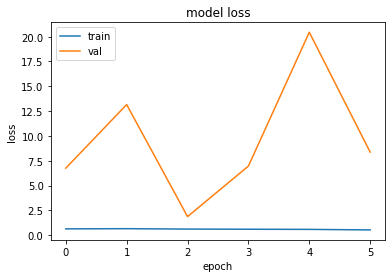

Iteration #4
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet50
Epoch 1/20
66/66 [==============================] - 46s 692ms/step - loss: 0.4998 - accuracy: 0.8081 - precision: 0.7945 - recall: 0.7787 - auc: 0.8935 - val_loss: 4.2546 - val_accuracy: 0.5465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5105 - lr: 1.2500e-04
Epoch 2/20
66/66 [==============================] - 45s 684ms/step - loss: 0.5115 - accuracy: 0.8038 - precision: 0.7851 - recall: 0.7818 - auc: 0.8836 - val_loss: 2.1618 - val_accuracy: 0.4573 - val_precision: 0.4552 - val_recall: 1.0000 - val_auc: 0.8862 - lr: 1.2500e-04
Epoch 3/20
66/66 [==============================] - 45s 674ms/step - loss: 0.4912 - accuracy: 0.8005 - precision: 0.7782 - recall: 0.7839 - auc: 0.8881 - val_loss: 3.8482 - val_accuracy: 0.4535 - val_precision: 0.4535 - val_recall: 1.0000 - val_auc: 0.5235 - lr: 1.2500e-04
Epoch 4/20
66/66 [=========

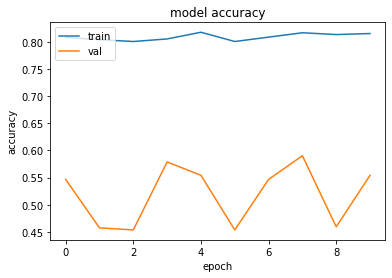

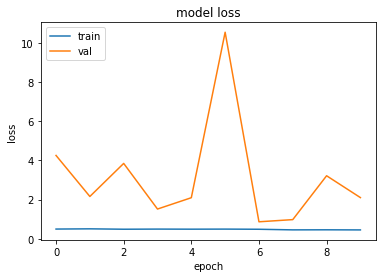

Iteration #5
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet50
Epoch 1/20
66/66 [==============================] - 46s 689ms/step - loss: 0.4281 - accuracy: 0.8213 - precision: 0.8010 - recall: 0.8069 - auc: 0.9081 - val_loss: 4.8258 - val_accuracy: 0.5465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5063 - lr: 3.1250e-05
Epoch 2/20
66/66 [==============================] - 47s 716ms/step - loss: 0.4457 - accuracy: 0.8199 - precision: 0.7955 - recall: 0.8121 - auc: 0.8987 - val_loss: 0.6282 - val_accuracy: 0.7059 - val_precision: 0.9565 - val_recall: 0.3682 - val_auc: 0.9152 - lr: 3.1250e-05
Epoch 3/20
66/66 [==============================] - 44s 663ms/step - loss: 0.4261 - accuracy: 0.8227 - precision: 0.7949 - recall: 0.8215 - auc: 0.9069 - val_loss: 2.0327 - val_accuracy: 0.5503 - val_precision: 1.0000 - val_recall: 0.0084 - val_auc: 0.8519 - lr: 3.1250e-05
Epoch 4/20
66/66 [=========

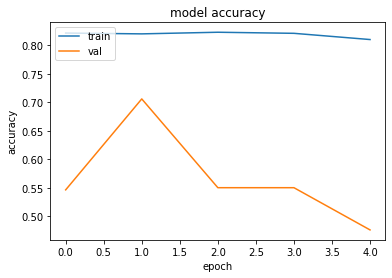

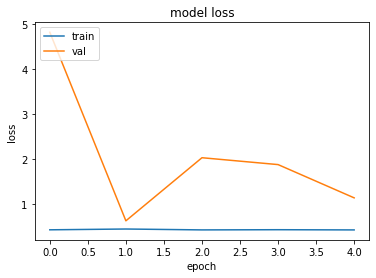

Iteration #1
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
resnet152
Epoch 1/20
66/66 [==============================] - 72s 927ms/step - loss: 3.8185 - accuracy: 0.7767 - precision: 0.7505 - recall: 0.7607 - auc: 0.8512 - val_loss: 2.3752 - val_accuracy: 0.8068 - val_precision: 0.8416 - val_recall: 0.7083 - val_auc: 0.8959 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 55s 827ms/step - loss: 1.7546 - accuracy: 0.8284 - precision: 0.8189 - recall: 0.7983 - auc: 0.9048 - val_loss: 1.5821 - val_accuracy: 0.7936 - val_precision: 0.7191 - val_recall: 0.8958 - val_auc: 0.8921 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 53s 799ms/step - loss: 1.3374 - accuracy: 0.8260 - precision: 0.8079 - recall: 0.8088 - auc: 0.9102 - val_loss: 1.4959 - val_accuracy: 0.7633 - val_precision: 0.8859 - val_recall: 0.5500 - val_auc: 0.8742 - lr: 0.0010
Epoch 4/20
66/66 [============================

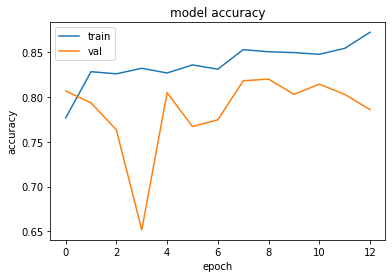

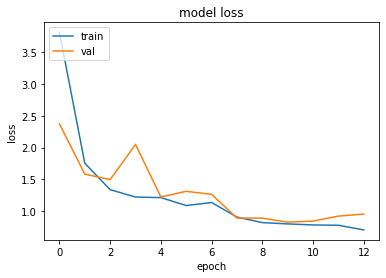

Iteration #2
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
resnet152
Epoch 1/20
66/66 [==============================] - 57s 868ms/step - loss: 0.6665 - accuracy: 0.8554 - precision: 0.8382 - recall: 0.8443 - auc: 0.9341 - val_loss: 0.6516 - val_accuracy: 0.8466 - val_precision: 0.8118 - val_recall: 0.8625 - val_auc: 0.9339 - lr: 2.5000e-04
Epoch 2/20
66/66 [==============================] - 60s 909ms/step - loss: 0.6425 - accuracy: 0.8615 - precision: 0.8541 - recall: 0.8380 - auc: 0.9381 - val_loss: 0.6460 - val_accuracy: 0.8617 - val_precision: 0.9326 - val_recall: 0.7500 - val_auc: 0.9492 - lr: 2.5000e-04
Epoch 3/20
66/66 [==============================] - 63s 946ms/step - loss: 0.6059 - accuracy: 0.8691 - precision: 0.8536 - recall: 0.8589 - auc: 0.9492 - val_loss: 0.6070 - val_accuracy: 0.8788 - val_precision: 0.8697 - val_recall: 0.8625 - val_auc: 0.9507 - lr: 2.5000e-04
Epoch 4/20
66/66 [================

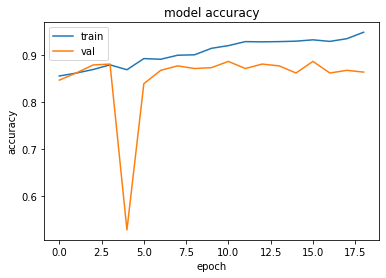

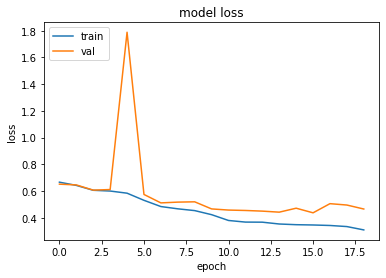

Iteration #3
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet152
Epoch 1/20
66/66 [==============================] - 58s 873ms/step - loss: 0.3416 - accuracy: 0.9284 - precision: 0.9216 - recall: 0.9207 - auc: 0.9784 - val_loss: 0.2930 - val_accuracy: 0.9545 - val_precision: 0.9352 - val_recall: 0.9665 - val_auc: 0.9912 - lr: 3.1250e-05
Epoch 2/20
66/66 [==============================] - 61s 928ms/step - loss: 0.3103 - accuracy: 0.9431 - precision: 0.9329 - recall: 0.9426 - auc: 0.9851 - val_loss: 0.2799 - val_accuracy: 0.9564 - val_precision: 0.9576 - val_recall: 0.9456 - val_auc: 0.9923 - lr: 3.1250e-05
Epoch 3/20
66/66 [==============================] - 53s 806ms/step - loss: 0.2960 - accuracy: 0.9464 - precision: 0.9433 - recall: 0.9384 - auc: 0.9873 - val_loss: 0.2900 - val_accuracy: 0.9488 - val_precision: 0.9609 - val_recall: 0.9247 - val_auc: 0.9890 - lr: 3.1250e-05
Epoch 4/20
66/66 [================

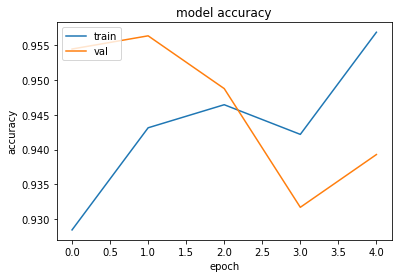

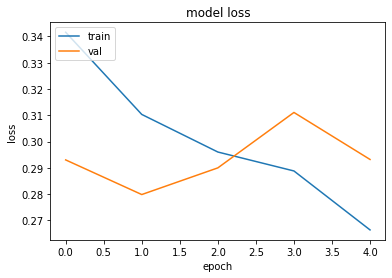

Iteration #4
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet152
Epoch 1/20
66/66 [==============================] - 56s 850ms/step - loss: 0.2780 - accuracy: 0.9455 - precision: 0.9341 - recall: 0.9468 - auc: 0.9885 - val_loss: 0.2133 - val_accuracy: 0.9848 - val_precision: 0.9957 - val_recall: 0.9707 - val_auc: 0.9994 - lr: 1.5625e-05
Epoch 2/20
66/66 [==============================] - 55s 827ms/step - loss: 0.2677 - accuracy: 0.9536 - precision: 0.9470 - recall: 0.9509 - auc: 0.9900 - val_loss: 0.2053 - val_accuracy: 0.9829 - val_precision: 0.9873 - val_recall: 0.9749 - val_auc: 0.9992 - lr: 1.5625e-05
Epoch 3/20
66/66 [==============================] - 52s 788ms/step - loss: 0.2485 - accuracy: 0.9602 - precision: 0.9505 - recall: 0.9624 - auc: 0.9935 - val_loss: 0.2055 - val_accuracy: 0.9848 - val_precision: 0.9873 - val_recall: 0.9791 - val_auc: 0.9993 - lr: 1.5625e-05
Epoch 4/20
66/66 [================

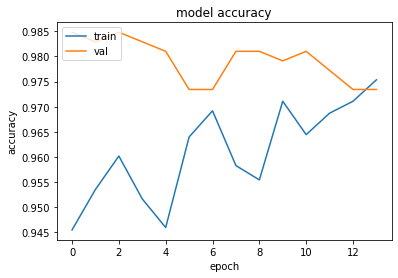

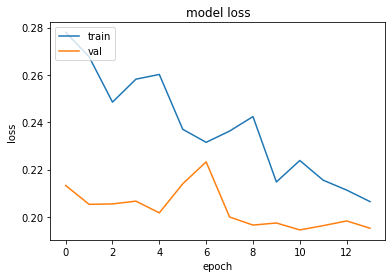

Iteration #5
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
resnet152
Epoch 1/20
66/66 [==============================] - 56s 849ms/step - loss: 0.2174 - accuracy: 0.9645 - precision: 0.9642 - recall: 0.9572 - auc: 0.9950 - val_loss: 0.1609 - val_accuracy: 0.9943 - val_precision: 0.9876 - val_recall: 1.0000 - val_auc: 0.9991 - lr: 1.0000e-05
Epoch 2/20
66/66 [==============================] - 53s 805ms/step - loss: 0.2092 - accuracy: 0.9692 - precision: 0.9656 - recall: 0.9666 - auc: 0.9955 - val_loss: 0.1630 - val_accuracy: 0.9905 - val_precision: 0.9875 - val_recall: 0.9916 - val_auc: 0.9993 - lr: 1.0000e-05
Epoch 3/20
66/66 [==============================] - 52s 785ms/step - loss: 0.2152 - accuracy: 0.9630 - precision: 0.9574 - recall: 0.9614 - auc: 0.9945 - val_loss: 0.1617 - val_accuracy: 0.9943 - val_precision: 0.9876 - val_recall: 1.0000 - val_auc: 0.9995 - lr: 1.0000e-05
Epoch 4/20
66/66 [================

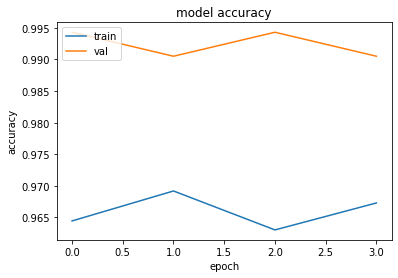

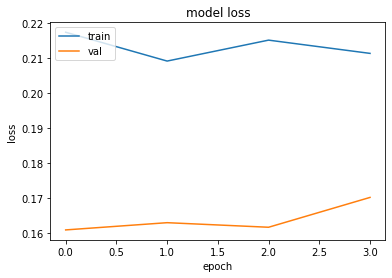

Iteration #1
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
inception
Epoch 1/20
66/66 [==============================] - 52s 703ms/step - loss: 2.6954 - accuracy: 0.7165 - val_loss: 0.5898 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 43s 653ms/step - loss: 0.5070 - accuracy: 0.7477 - val_loss: 0.4133 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 41s 621ms/step - loss: 0.4279 - accuracy: 0.7662 - val_loss: 0.4182 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.7696
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 42s 633ms/step - loss: 0.4537 - accuracy: 0.7696 - val_loss: 0.4978 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 5/20
66/66 [==============================] - 42s 642ms/step - loss

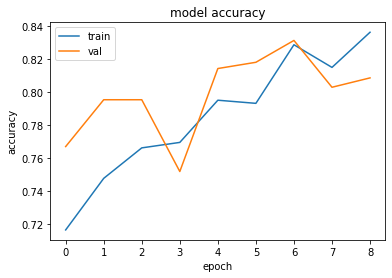

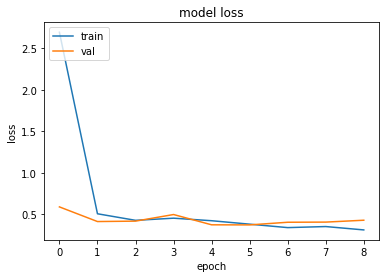

Iteration #2
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
inception
Epoch 1/20
66/66 [==============================] - 42s 631ms/step - loss: 0.3692 - accuracy: 0.8236 - val_loss: 0.2456 - val_accuracy: 0.8712 - lr: 2.5000e-04
Epoch 2/20
66/66 [==============================] - 43s 653ms/step - loss: 0.3549 - accuracy: 0.8407 - val_loss: 0.2475 - val_accuracy: 0.8750 - lr: 2.5000e-04
Epoch 3/20
66/66 [==============================] - 45s 671ms/step - loss: 0.3453 - accuracy: 0.8397 - val_loss: 0.2300 - val_accuracy: 0.8845 - lr: 2.5000e-04
Epoch 4/20
66/66 [==============================] - 43s 652ms/step - loss: 0.3311 - accuracy: 0.8359 - val_loss: 0.2408 - val_accuracy: 0.8883 - lr: 2.5000e-04
Epoch 5/20
66/66 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8312
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
66/66 [==============================] - 41s 6

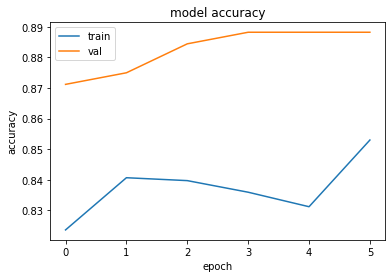

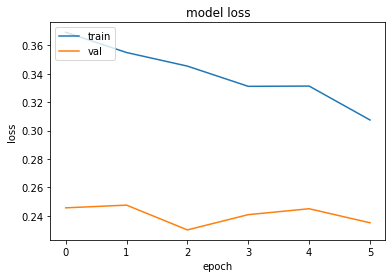

Iteration #3
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
inception
Epoch 1/20
66/66 [==============================] - 45s 679ms/step - loss: 0.3044 - accuracy: 0.8564 - val_loss: 0.2354 - val_accuracy: 0.8786 - lr: 1.2500e-04
Epoch 2/20
66/66 [==============================] - 43s 649ms/step - loss: 0.3166 - accuracy: 0.8351 - val_loss: 0.2355 - val_accuracy: 0.8805 - lr: 1.2500e-04
Epoch 3/20
66/66 [==============================] - 44s 673ms/step - loss: 0.3055 - accuracy: 0.8488 - val_loss: 0.2293 - val_accuracy: 0.8918 - lr: 1.2500e-04
Epoch 4/20
66/66 [==============================] - 41s 625ms/step - loss: 0.2983 - accuracy: 0.8583 - val_loss: 0.2358 - val_accuracy: 0.8824 - lr: 1.2500e-04
Epoch 5/20
66/66 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8469
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
66/66 [==============================] - 40s 61

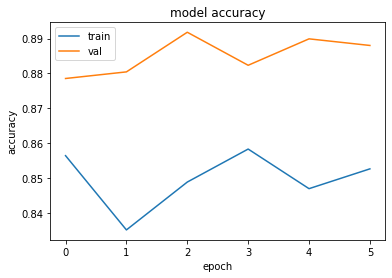

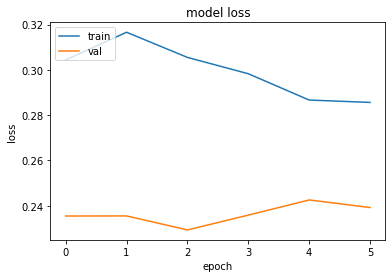

Iteration #4
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
inception
Epoch 1/20
66/66 [==============================] - 43s 653ms/step - loss: 0.2942 - accuracy: 0.8521 - val_loss: 0.2285 - val_accuracy: 0.9146 - lr: 6.2500e-05
Epoch 2/20
66/66 [==============================] - 41s 620ms/step - loss: 0.2781 - accuracy: 0.8630 - val_loss: 0.2267 - val_accuracy: 0.9051 - lr: 6.2500e-05
Epoch 3/20
66/66 [==============================] - 40s 609ms/step - loss: 0.2949 - accuracy: 0.8455 - val_loss: 0.2336 - val_accuracy: 0.9051 - lr: 6.2500e-05
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8550
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
66/66 [==============================] - 40s 611ms/step - loss: 0.2928 - accuracy: 0.8550 - val_loss: 0.2414 - val_accuracy: 0.9032 - lr: 6.2500e-05
Epoch 5/20
66/66 [==============================] - 41s 6

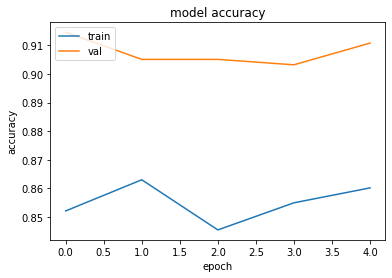

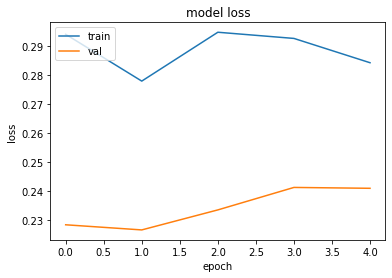

Iteration #5
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
inception
Epoch 1/20
66/66 [==============================] - 42s 637ms/step - loss: 0.2925 - accuracy: 0.8536 - val_loss: 0.1954 - val_accuracy: 0.9203 - lr: 3.1250e-05
Epoch 2/20
66/66 [==============================] - 41s 625ms/step - loss: 0.2901 - accuracy: 0.8607 - val_loss: 0.1926 - val_accuracy: 0.9203 - lr: 3.1250e-05
Epoch 3/20
66/66 [==============================] - 41s 613ms/step - loss: 0.2807 - accuracy: 0.8521 - val_loss: 0.2010 - val_accuracy: 0.9165 - lr: 3.1250e-05
Epoch 4/20
66/66 [==============================] - 41s 626ms/step - loss: 0.2860 - accuracy: 0.8635 - val_loss: 0.1917 - val_accuracy: 0.9165 - lr: 3.1250e-05
Epoch 5/20
66/66 [==============================] - 41s 614ms/step - loss: 0.2774 - accuracy: 0.8578 - val_loss: 0.1956 - val_accuracy: 0.9184 - lr: 3.1250e-05
Epoch 6/20
66/66 [==============================] - ETA:

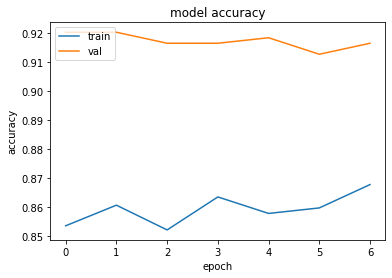

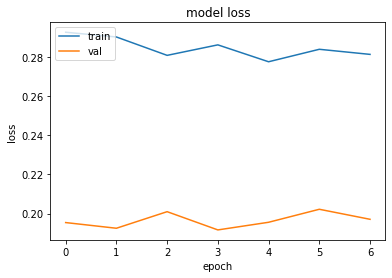

In [ ]:
# cross_validate(xception,'xception')
# cross_validate(vgg16,'vgg16')
# cross_validate(vgg19,'vgg19')
cross_validate(resnet50,'resnet50')
cross_validate(resnet152,'resnet152')
cross_validate(inception,'inception')

Iteration #1
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
vgg19
Epoch 1/20
66/66 [==============================] - 68s 945ms/step - loss: 0.5468 - accuracy: 0.7359 - val_loss: 0.5164 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 51s 764ms/step - loss: 0.4585 - accuracy: 0.7819 - val_loss: 0.5149 - val_accuracy: 0.7178 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 52s 782ms/step - loss: 0.4314 - accuracy: 0.8004 - val_loss: 0.4149 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/20
66/66 [==============================] - 51s 767ms/step - loss: 0.4334 - accuracy: 0.8023 - val_loss: 0.4480 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 5/20
66/66 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8084
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 50s 757ms/step - loss: 0.

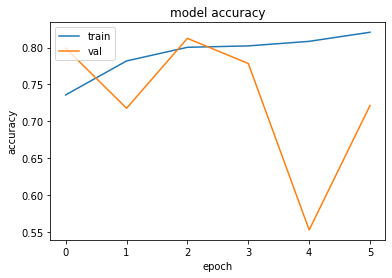

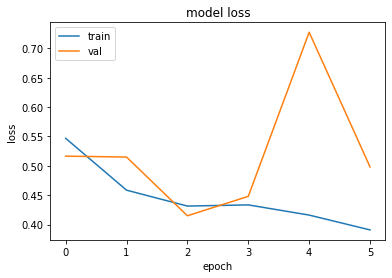

Iteration #2
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
vgg19
Epoch 1/20
66/66 [==============================] - 55s 828ms/step - loss: 0.3812 - accuracy: 0.8212 - val_loss: 0.4096 - val_accuracy: 0.8636 - lr: 5.0000e-04
Epoch 2/20
66/66 [==============================] - 50s 758ms/step - loss: 0.3775 - accuracy: 0.8250 - val_loss: 0.4383 - val_accuracy: 0.7633 - lr: 5.0000e-04
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8402
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
66/66 [==============================] - 51s 770ms/step - loss: 0.3601 - accuracy: 0.8402 - val_loss: 0.4296 - val_accuracy: 0.7803 - lr: 5.0000e-04
Epoch 4/20
66/66 [==============================] - 50s 753ms/step - loss: 0.3450 - accuracy: 0.8468 - val_loss: 0.3607 - val_accuracy: 0.8598 - lr: 2.5000e-04
Epoch 5/20
66/66 [==============================] - 50s 748ms

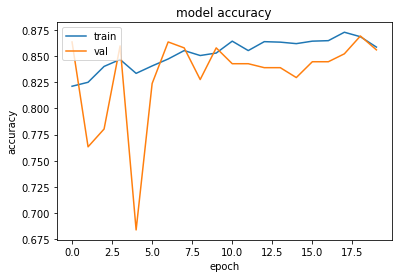

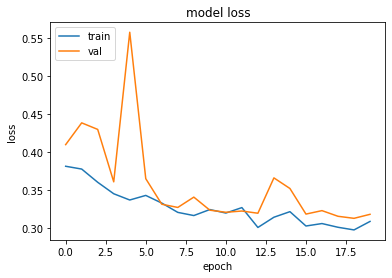

Iteration #3
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
vgg19
Epoch 1/20
66/66 [==============================] - 61s 921ms/step - loss: 0.2966 - accuracy: 0.8659 - val_loss: 0.2623 - val_accuracy: 0.8843 - lr: 6.2500e-05
Epoch 2/20
66/66 [==============================] - 50s 750ms/step - loss: 0.3069 - accuracy: 0.8659 - val_loss: 0.2774 - val_accuracy: 0.8767 - lr: 6.2500e-05
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8621
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
66/66 [==============================] - 49s 743ms/step - loss: 0.3129 - accuracy: 0.8621 - val_loss: 0.2668 - val_accuracy: 0.8786 - lr: 6.2500e-05
Epoch 4/20
66/66 [==============================] - 49s 743ms/step - loss: 0.2936 - accuracy: 0.8720 - val_loss: 0.2602 - val_accuracy: 0.8824 - lr: 3.1250e-05
Epoch 5/20
66/66 [==============================] - 49s 742ms

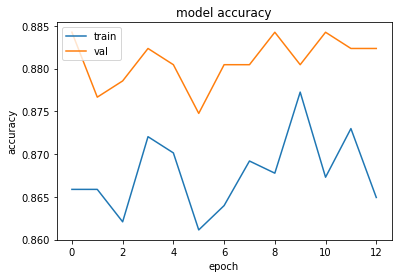

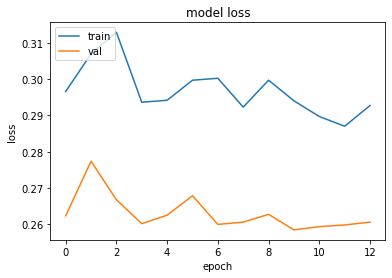

Iteration #4
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
vgg19
Epoch 1/20
66/66 [==============================] - 50s 752ms/step - loss: 0.2891 - accuracy: 0.8711 - val_loss: 0.2773 - val_accuracy: 0.8691 - lr: 1.0000e-05
Epoch 2/20
66/66 [==============================] - 50s 748ms/step - loss: 0.2831 - accuracy: 0.8758 - val_loss: 0.2895 - val_accuracy: 0.8577 - lr: 1.0000e-05
Epoch 3/20
66/66 [==============================] - 50s 757ms/step - loss: 0.2937 - accuracy: 0.8664 - val_loss: 0.2765 - val_accuracy: 0.8672 - lr: 1.0000e-05
Epoch 4/20
66/66 [==============================] - 51s 772ms/step - loss: 0.2849 - accuracy: 0.8682 - val_loss: 0.2749 - val_accuracy: 0.8710 - lr: 1.0000e-05
Epoch 5/20
66/66 [==============================] - 51s 776ms/step - loss: 0.2858 - accuracy: 0.8773 - val_loss: 0.2841 - val_accuracy: 0.8805 - lr: 1.0000e-05
Epoch 6/20
66/66 [==============================] - 50s 747m

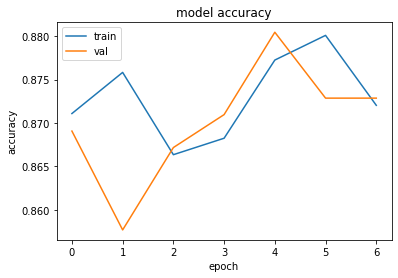

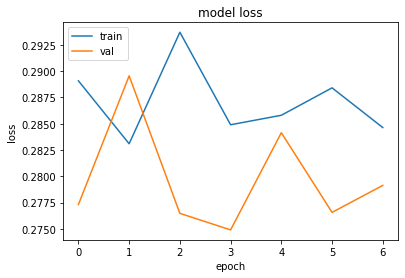

Iteration #5
Found 2110 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
vgg19
Epoch 1/20
66/66 [==============================] - 50s 761ms/step - loss: 0.2968 - accuracy: 0.8682 - val_loss: 0.2238 - val_accuracy: 0.9070 - lr: 1.0000e-05
Epoch 2/20
66/66 [==============================] - 50s 753ms/step - loss: 0.2934 - accuracy: 0.8720 - val_loss: 0.2295 - val_accuracy: 0.8975 - lr: 1.0000e-05
Epoch 3/20
66/66 [==============================] - 49s 748ms/step - loss: 0.2850 - accuracy: 0.8768 - val_loss: 0.2315 - val_accuracy: 0.8975 - lr: 1.0000e-05
Epoch 4/20
66/66 [==============================] - 52s 789ms/step - loss: 0.2995 - accuracy: 0.8682 - val_loss: 0.2297 - val_accuracy: 0.9089 - lr: 1.0000e-05
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


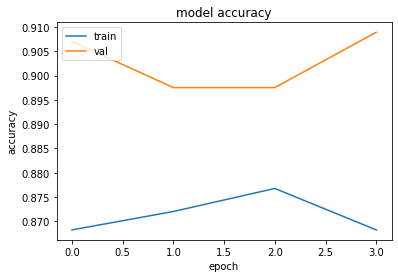

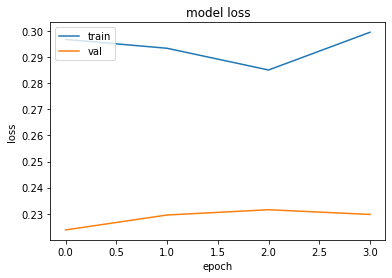

In [ ]:
cross_validate(vgg19,'vgg19')

**Evaluate**

In [ ]:
test_set = test_data_gen.flow_from_directory(directory=train_path,
                                             class_mode="binary",
                                             target_size=(img_width,img_height), batch_size=batch_size)
preds = model.evaluate(test_set)

Found 2637 images belonging to 2 classes.
132/132 [==============================] - 368s 3s/step - loss: 0.7241 - accuracy: 0.5461


## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)